There are 4 sections in this IPYNB notebook

Section 1 - LSTM, Attention Model training

Section 2 - GRU Model

Section 3 - RNN Model

Section 4 - Transfer Learning with LSTM and Attention Models

# SECTION 1

This is a Section that highlights the usage of three different approaches
Section 1 is about model training (LSTM and Attention) and Section 4 is Transfer Learning done using these 4 models.

*   **LSTM**
    1.   With Text Cleaning
    2.   Without Text Cleaning
*   **Attention**
    1.   With Text Cleaning
    2.   Without Text Cleaning
*   **Transfer Learning**
    1.  Using LSTM With Text Cleaning
    2.  Using Attention With Text Cleaning
    3.  Using LSTM Without Text Cleaning
    4.  Using Attention Without Text Cleaning  

I've addressed a NPL problem (Sentiment Analysis) using these three approaches.
This involves usage of publically available datasets from Kaggle.

## Importing and Downloading necessary libraries

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import nltk
import pickle
import re
!pip install emoji
import emoji
# wordnet is a library that can be used to identify whether a word has meaning, the part of speech of that word etc.
nltk.download('wordnet')
# Stopwords are some of the words in any language that makes a sentence correct gramatically but doesn't carry any significant meaning in it.
nltk.download('stopwords')
# punkt is used to download the PorterStemmer which can be used to reduce words to their base or root form
nltk.download('punkt')
import string
import pandas as pd
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# This keras-self-attention is not pre installed in Google colab hence I'm installing and importing this to make comparisons
!pip install keras-self-attention
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.optimizers import Adam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 2.6 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=ab2d2c655e9beee7219b7fbcbb5ebe048bc7b4bcf590870051c8ccb22f409e81
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


## User defined functions

### Tweet Cleansing (or) Data Cleaning


In [2]:
stemmer = PorterStemmer()
# Creating a function to apply all steps easily just by calling this both of train and test datasets
def tweet_cleansing(x,stemmer=stemmer):
  x = str(x).lower()
  step1 = ''.join([i for i in x if i not in string.punctuation])
  step2 = ''.join([i for i in step1 if i not in string.digits])
  meaningful_words = [word for word in step2.split(' ') if wordnet.synsets(word)]
  stop_words_removal = [word for word in meaningful_words if word not in stopwords.words('english')]
  stemmed_words = [stemmer.stem(word) for word in stop_words_removal]
  return ' '.join(stemmed_words)

# These steps include, Converting the characters to lower case, removing punctuations and digits, removing meaningless words (any @ mentions of the user ID as well in our case),
# removing stop words (English Language) and finally reducing the words to it's root form using stemmer.

### Label formatting

In [3]:
# We are using LSTM to create a model using one dataset and used that Model to perform transfer learning in another dataset.
# Since this involves the usage of two different datasets, We've created this function that we are using to convert the lables to match the required format while performing lable encoding
def equalise(x):
  if(x==-1):
    return('negative')
  elif(x==0):
    return('neutral')
  elif(x==1):
    return('positive')

### Plotting

In [4]:
# Creating a function to plot two graphs highlighting the best epoch, best validation accuracy and loss both in Train as well as Validation data splits
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot accuracy
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(['Train', 'Validation'], loc='upper left')
    best_epoch_acc = np.argmax(history.history['val_accuracy'])
    best_val_acc = history.history['val_accuracy'][best_epoch_acc]
    axes[0].axvline(x=best_epoch_acc, color='r', linestyle='--', label='Best Epoch')
    axes[0].axhline(y=best_val_acc, color='g', linestyle='--', label='Best Validation Accuracy')
    axes[0].legend(['Train', 'Validation','Best Epoch', 'Best Validation Accuracy'], loc='upper left')

    # Plot loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    best_epoch_loss = np.argmin(history.history['val_loss'])
    best_val_loss = history.history['val_loss'][best_epoch_loss]
    axes[1].axvline(x=best_epoch_loss, color='r', linestyle='--', label='Best Epoch')
    axes[1].axhline(y=best_val_loss, color='g', linestyle='--', label='Best Validation Loss')
    axes[1].legend(['Train', 'Validation','Best Epoch', 'Best Validation Loss'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [5]:
def plotter(model, X_test_pad, y_test, model_name, tokenizer):
    y_pred_probs = model.predict(X_test_pad)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Word Clouds
    def plot_word_cloud_for_class(ax, class_label, title, tweets):
        class_tweets = ' '.join(X_test[y_pred == class_label])
        wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(class_tweets)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis('off')
        ax.set_title(title)

    fig, axes = plt.subplots(1, 2, figsize=(13, 5), gridspec_kw={'width_ratios': [1, 2]})

    # Plot Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Plot Word Clouds for each class
    # Get the weights of the embedding layer
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]

    # Get the word index from the Tokenizer
    word_index = tokenizer.word_index

    # Create a reverse mapping from index to word
    reverse_word_index = {index: word for word, index in word_index.items()}

    # Extract the vectors corresponding to each word
    word_vectors = {}
    for word, index in word_index.items():
        if index < max_words:
            word_vectors[word] = np.linalg.norm(weights[index])

    # Visualize the word vectors using a Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_vectors)
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].axis('off')
    axes[1].set_title('Word Cloud')

    fig.suptitle(model_name, fontsize=16)
    plt.tight_layout()
    plt.show()

## Working with Kaggle dataset

Please make sure to download your Kaggle API Key and put it in the workspace directory before executing the below code. Else, download the datasets manually and extract it in the same location and skip the next 2 steps

In [6]:
# Setting up my Kaggle api to download necessary datasets directly
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d crowdflower/twitter-airline-sentiment
!unzip twitter-airline-sentiment

 39% 1.00M/2.55M [00:00<00:00, 8.16MB/s]
100% 2.55M/2.55M [00:00<00:00, 19.0MB/s]
Archive:  twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


In [ ]:
df2 = pd.read_csv('Tweets.csv')

The CrowdFlower/Twitter Airline Sentiment dataset is just a collection of tweets related to various airlines and their sentiment. Each entry in the dataset represents a tweet, and the sentiments expressed in the tweets are categorized into three classes: positive, negative, and neutral. The dataset was originally created for a sentiment analysis task, where the goal is to determine the sentiment or opinion expressed in a given text.

In [ ]:
df2['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [ ]:
df2.head(5)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [ ]:
# Creating a copy if this dataset and preparing
df3 = df2[['airline_sentiment','text']].copy()
df3.columns = ['Target','Tweet']
df3['Tweet'] = df3['Tweet'].apply(tweet_cleansing)
df3.head(5)
# Here is the text after Cleaning

Target                                              Tweet
0   neutral                                               said
1  positive                       plu ad commerci experi tacki
2   neutral               today must mean need take anoth trip
3  negative  realli aggress blast obnoxi entertain guest fa...
4  negative                               realli big bad thing

<Axes: >

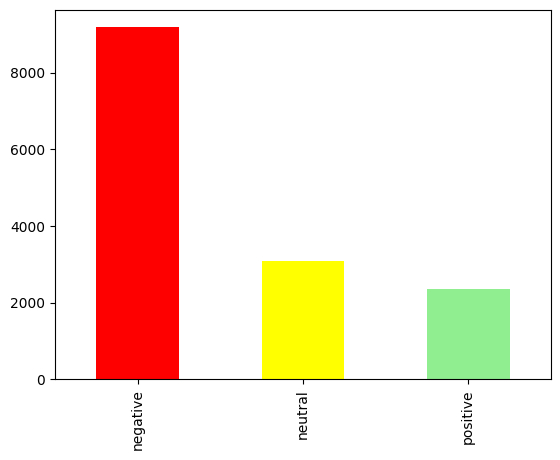

In [ ]:
df3['Target'].value_counts().plot(kind='bar', color=['red', 'yellow', 'lightgreen'])

## Some main variables in this notebook

I have used these variables multiple times in this notebook

**max_words** :

This is the maximum number of words that we save in our pool. These are the words that are encoded. Anything which is not in this pool will be truncated

**max_len** :

This is the maximum length each sentence can have. If a sentence has length less than this value then the remaining values are padded with 0. If it has a length more than this value then the remaining values are truncated.

**early_stopping** :

This is used to stop the model training and retain the best trained epoch using a variable called patience that denotes the number of epochs that the model can wait to check if the val_loss is decreasing.

## **LSTM MODELS**

### LSTM Model **with** Text Cleaning

#### Model training

In [ ]:
X = df3['Tweet']
y = df3['Target']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42,shuffle = True,stratify=y_encoded)

# Tokenize and pad sequences
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
tokenizer_path = 'LSTM_C.pickle'
with open(tokenizer_path, 'wb') as tkn:
    pickle.dump(tokenizer, tkn, protocol=pickle.HIGHEST_PROTOCOL)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build the LSTM model
embedding_dim = 100
# Creating a model architecture using the sequential model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(100))
#model.add(Dense(100))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the LSTM model
model_history = model.fit(X_train_pad, y_train, epochs=25, batch_size=32, validation_split=0.1,shuffle=True,callbacks=[early_stopping])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 1,080,703
Trainable params: 1,080,703
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
330/330 [==============================] - 24s 64ms/step - loss: 0.6704 - accuracy: 0.7283 - val_loss: 0.5633 - val_accuracy: 0.7705
Epoch 2/25
330/330 [==============================] - 20s 62ms/step - loss: 0.4614 - accuracy: 0.8184 - val_loss: 0.5619 - val_accuracy: 0.7671
Epoch 3/25
330/330 [==

#### Model Evaluation

In [ ]:
# Evaluating the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

92/92 [==============================] - 2s 20ms/step - loss: 0.5636 - accuracy: 0.7842
Test Loss: 0.5636186599731445, Test Accuracy: 0.7841529846191406


#### Word Cloud and Confussion matrix

92/92 [==============================] - 2s 20ms/step


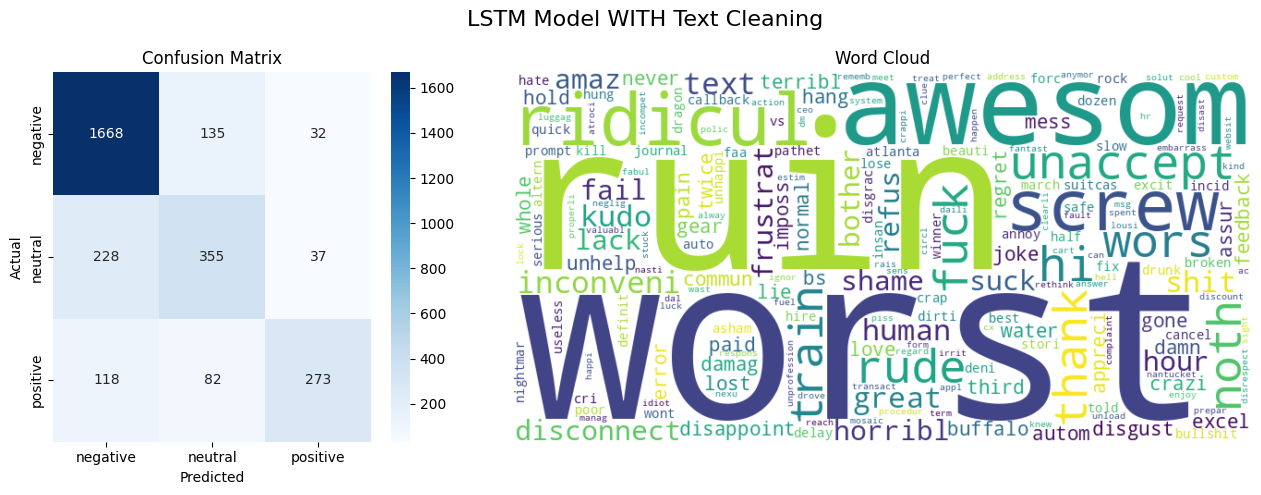

In [ ]:
plotter(model,X_test_pad,y_test,"LSTM Model WITH Text Cleaning",tokenizer)

#### Graph Plot

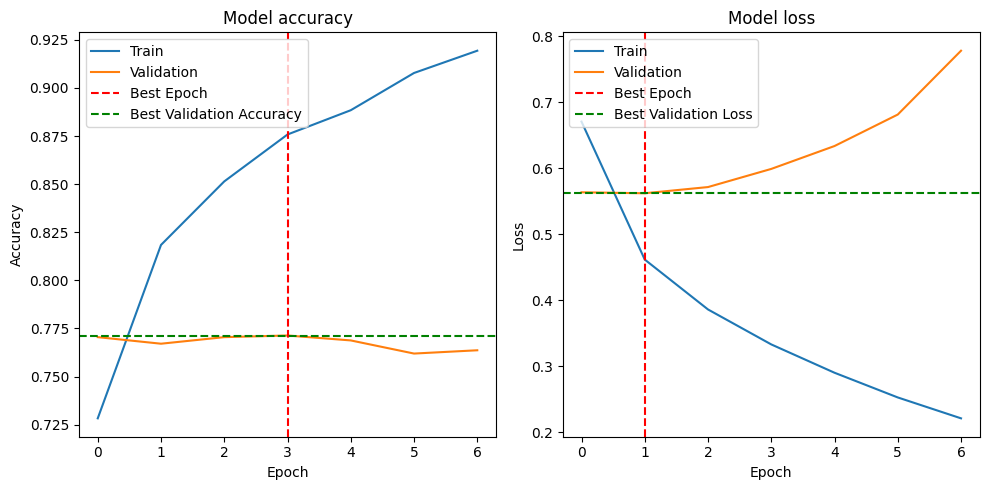

In [ ]:
plot_history(model_history)

### LSTM Model **without** Text Cleaning

#### Model training

In [ ]:
X = df2['text']
y = df2['airline_sentiment']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2,
                                                    random_state=42,
                                                    shuffle = True,stratify=y_encoded)

# Tokenize and pad sequences
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
tokenizer_path = 'LSTM_U.pickle'
with open(tokenizer_path, 'wb') as tkn:
    pickle.dump(tokenizer, tkn, protocol=pickle.HIGHEST_PROTOCOL)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build the LSTM unCleaned_model
embedding_dim = 100

unCleaned_model = Sequential()
unCleaned_model.add(Embedding(input_dim=max_words, output_dim=embedding_dim,
                                input_length=max_len))
unCleaned_model.add(LSTM(100))
#unCleaned_model.add(Dense(100))
unCleaned_model.add(Dense(num_classes, activation='softmax'))

unCleaned_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
unCleaned_model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True)
# Train the unCleaned LSTM model
unCleaned_model_history = unCleaned_model.fit(X_train_pad, y_train,
                                                  epochs=25, batch_size=32,
                                                  validation_split=0.1,
                                                  shuffle=True,
                                                  callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 1,080,703
Trainable params: 1,080,703
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
330/330 [==============================] - 23s 63ms/step - loss: 0.6495 - accuracy: 0.7292 - val_loss: 0.5674 - val_accuracy: 0.7739
Epoch 2/25
330/330 [==============================] - 20s 61ms/step - loss: 0.3806 - accuracy: 0.8542 - val_loss: 0.5233 - val_accuracy: 0.7986
Epoch 3/25
330/330 [

#### Model Evaluation

In [ ]:
# Evaluating the unCleaned model
loss, accuracy = unCleaned_model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

92/92 [==============================] - 2s 20ms/step - loss: 0.5134 - accuracy: 0.7964
Test Loss: 0.5134450793266296, Test Accuracy: 0.7964481115341187


#### Word Cloud and Confussion matrix

92/92 [==============================] - 2s 20ms/step


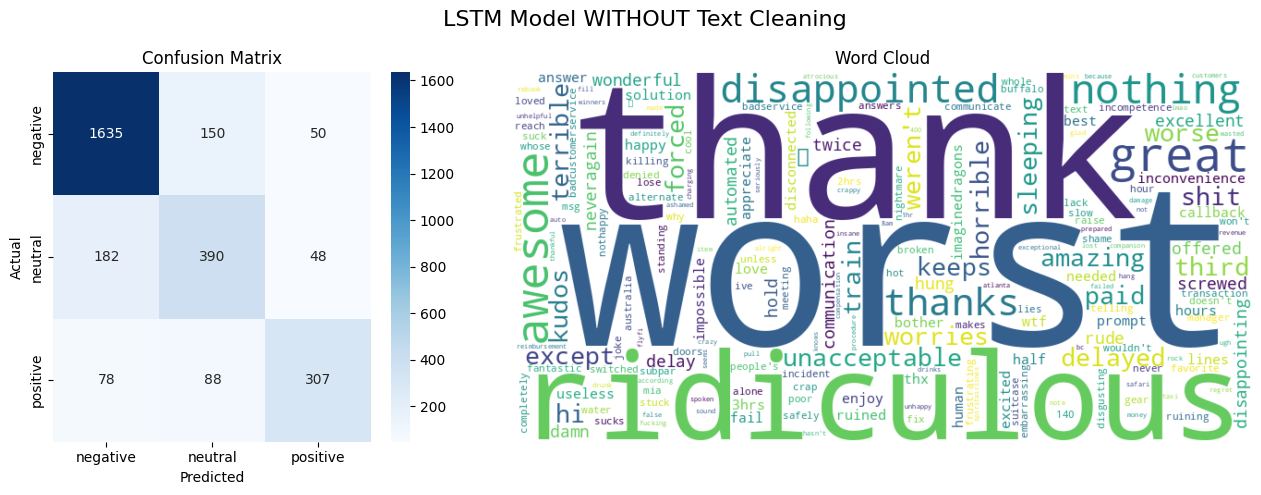

In [ ]:
plotter(unCleaned_model,X_test_pad,y_test,"LSTM Model WITHOUT Text Cleaning",tokenizer)

#### Graph Plot

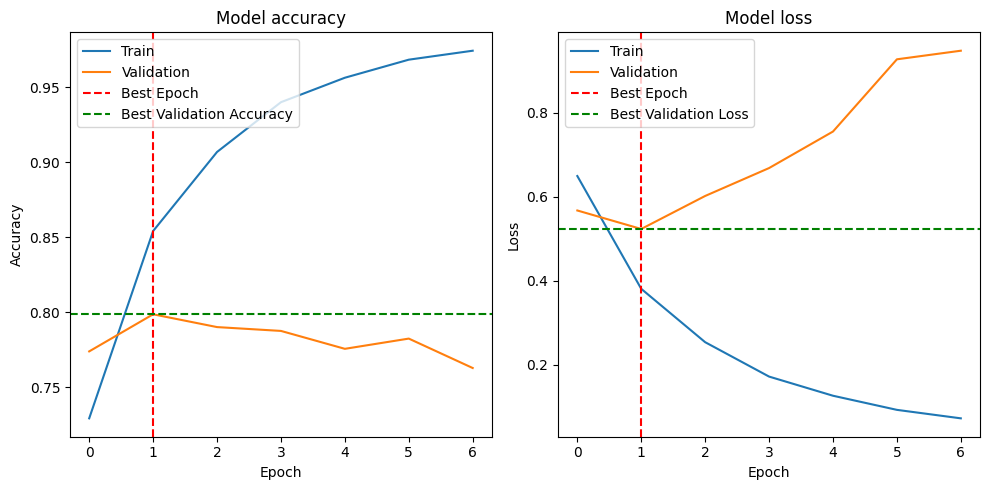

In [ ]:
plot_history(unCleaned_model_history)

## **ATTENTION MODELS**

### Attention Model **with** Text Cleaning

#### Model Training

In [ ]:
X = df3['Tweet']
y = df3['Target']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=True,stratify=y_encoded)

# Tokenize and pad sequences
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
tokenizer_path = 'ATTENTION_C.pickle'
with open(tokenizer_path, 'wb') as tkn:
    pickle.dump(tokenizer, tkn, protocol=pickle.HIGHEST_PROTOCOL)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build the attention model
embedding_dim = 50

att_model = Sequential()
att_model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
att_model.add(LSTM(100,return_sequences=True))
att_model.add(SeqSelfAttention(attention_activation='softmax', name='Attention'))
att_model.add(Flatten())
att_model.add(Dense(num_classes, activation='softmax'))

att_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
att_model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train the attention model
att_model_history = att_model.fit(X_train_pad, y_train, epochs=25, batch_size=24, validation_split=0.1,shuffle=True,callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           500000    
                                                                 
 lstm_2 (LSTM)               (None, 100, 100)          60400     
                                                                 
 Attention (SeqSelfAttention  (None, 100, 100)         6465      
 )                                                               
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 3)                 30003     
                                                                 
Total params: 596,868
Trainable params: 596,868
Non-trainable params: 0
________________________________________________

#### Model Evaluation

In [ ]:
# Module Evaluation
loss, accuracy = att_model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

92/92 [==============================] - 3s 34ms/step - loss: 0.5655 - accuracy: 0.7749
Test Loss: 0.5655223727226257, Test Accuracy: 0.7749316692352295


#### Word Cloud and Confussion matrix

92/92 [==============================] - 4s 33ms/step


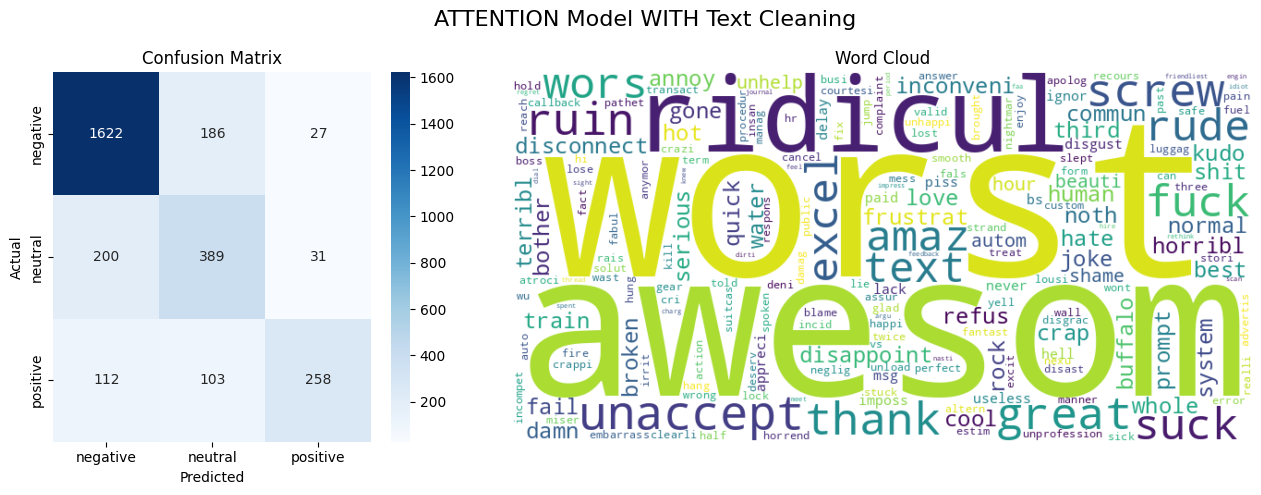

In [ ]:
plotter(att_model,X_test_pad,y_test,"ATTENTION Model WITH Text Cleaning",tokenizer)

#### Graph Plot

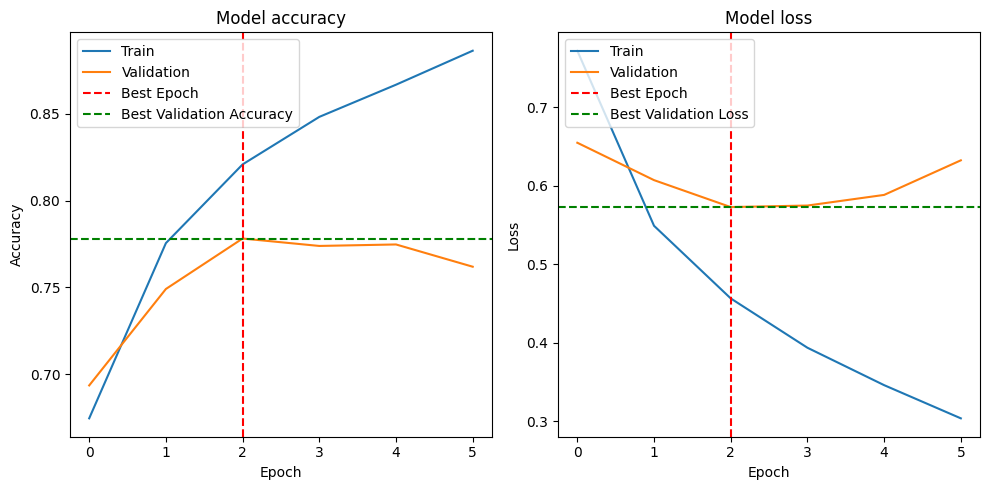

In [ ]:
plot_history(att_model_history)

### Attention Model **without** Text Cleaning

#### Model Training

In [ ]:
X = df2['text']
y = df2['airline_sentiment']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# STrain-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=True,stratify=y_encoded)

# Tokenize and pad sequences
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
tokenizer_path = 'ATTENTION_U.pickle'
with open(tokenizer_path, 'wb') as tkn:
    pickle.dump(tokenizer, tkn, protocol=pickle.HIGHEST_PROTOCOL)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Build the attention model
embedding_dim = 50

unCleaned_att_model = Sequential()
unCleaned_att_model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
unCleaned_att_model.add(LSTM(100,return_sequences=True))
unCleaned_att_model.add(SeqSelfAttention(attention_activation='softmax', name='Attention'))
unCleaned_att_model.add(Flatten())
unCleaned_att_model.add(Dense(num_classes, activation='softmax'))

unCleaned_att_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
unCleaned_att_model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train the unCleaned attention model
unCleaned_att_model_history = unCleaned_att_model.fit(X_train_pad, y_train, epochs=25, batch_size=24, validation_split=0.1,shuffle=True,callbacks=[early_stopping])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 50)           500000    
                                                                 
 lstm_3 (LSTM)               (None, 100, 100)          60400     
                                                                 
 Attention (SeqSelfAttention  (None, 100, 100)         6465      
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 3)                 30003     
                                                                 
Total params: 596,868
Trainable params: 596,868
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


440/440 [==============================] - 41s 86ms/step - loss: 0.7191 - accuracy: 0.6912 - val_loss: 0.5757 - val_accuracy: 0.7696
Epoch 2/25
440/440 [==============================] - 37s 84ms/step - loss: 0.4740 - accuracy: 0.8112 - val_loss: 0.5749 - val_accuracy: 0.7927
Epoch 3/25
440/440 [==============================] - 37s 84ms/step - loss: 0.3427 - accuracy: 0.8650 - val_loss: 0.5236 - val_accuracy: 0.7884
Epoch 4/25
440/440 [==============================] - 37s 83ms/step - loss: 0.2518 - accuracy: 0.9046 - val_loss: 0.6236 - val_accuracy: 0.7969
Epoch 5/25
440/440 [==============================] - 37s 84ms/step - loss: 0.1876 - accuracy: 0.9326 - val_loss: 0.7041 - val_accuracy: 0.7816
Epoch 6/25
440/440 [==============================] - 37s 84ms/step - loss: 0.1446 - accuracy: 0.9495 - val_loss: 0.7572 - val_accuracy: 0.7816


#### Model Evaluation

In [ ]:
# Module Evaluation
loss, accuracy = unCleaned_att_model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

92/92 [==============================] - 3s 34ms/step - loss: 0.5309 - accuracy: 0.7913
Test Loss: 0.5309358835220337, Test Accuracy: 0.7913251519203186


#### Word Cloud and Confussion matrix

92/92 [==============================] - 4s 33ms/step


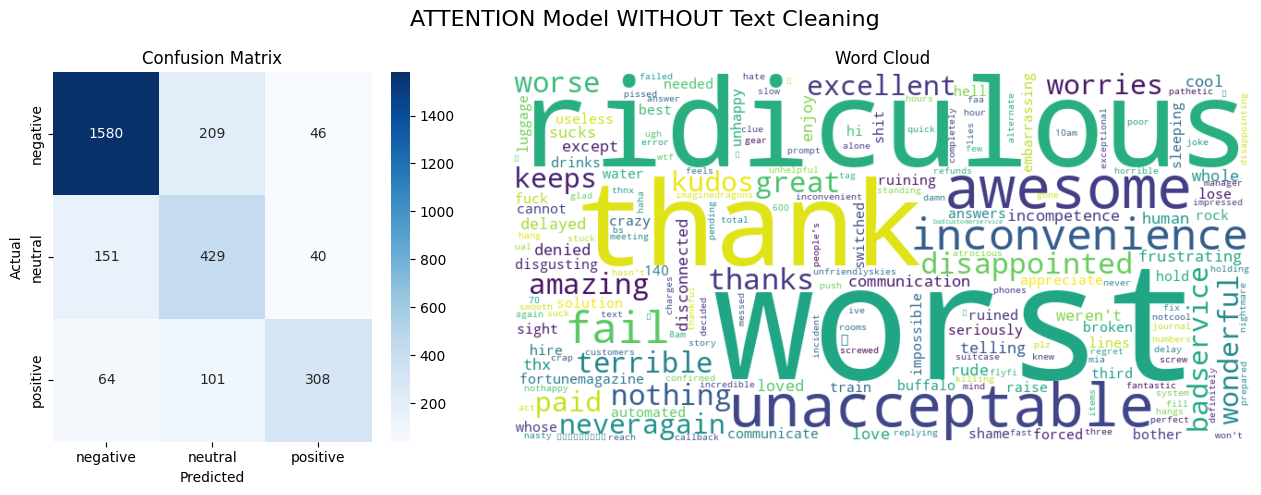

In [ ]:
plotter(unCleaned_att_model,X_test_pad,y_test,"ATTENTION Model WITHOUT Text Cleaning",tokenizer)

#### Graph plot

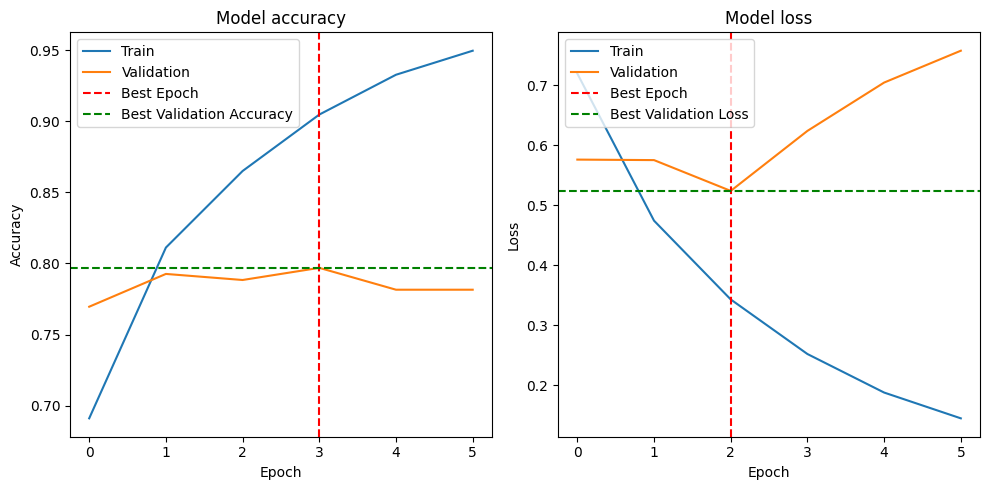

In [ ]:
plot_history(unCleaned_att_model_history)

### Comments on the dataset and model
This is a pretty good dataset and all 4 models performed well with this dataset and gave around 80% accuracy.

## SAVING THE TRAINED MODELS

In [ ]:
model.save('LSTM.h5')
unCleaned_model.save('LSTM_unCleaned.h5')
att_model.save("Attention.h5")
unCleaned_att_model.save("Attention_unCleaned.h5")

-------------------------------------------------------------------------------- **END OF SECTION 1** ----------------------------------------------------------------------------------

# SECTION 2

## GRU Model

In this section We will use a TensorFlow ANN (with a GRU) to make our predictions.

In [8]:
ps = PorterStemmer()

def process_tweet(tweet):
    new_tweet = tweet.lower()
    new_tweet = re.sub(r'@\w+', '', new_tweet) # Remove @s
    new_tweet = re.sub(r'#', '', new_tweet) # Remove hashtags
    new_tweet = re.sub(r':', ' ', emoji.demojize(new_tweet)) # Turn emojis into words
    new_tweet = re.sub(r'http\S+', '',new_tweet) # Remove URLs
    new_tweet = re.sub(r'\$\S+', 'dollar', new_tweet) # Change dollar amounts to dollar
    new_tweet = re.sub(r'[^a-z0-9\s]', '', new_tweet) # Remove punctuation
    new_tweet = re.sub(r'[0-9]+', 'number', new_tweet) # Change number values to number
    new_tweet = new_tweet.split(" ")
    new_tweet = list(map(lambda x: ps.stem(x), new_tweet)) # Stemming the words
    new_tweet = list(map(lambda x: x.strip(), new_tweet)) # Stripping whitespace from the words
    if '' in new_tweet:
        new_tweet.remove('')
    return new_tweet

In [9]:
data = pd.read_csv('Tweets.csv')

### Preprocessing

In [10]:
confidence_threshold = 0.6

data = data.drop(data.query("airline_sentiment_confidence < @confidence_threshold").index, axis=0).reset_index(drop=True)

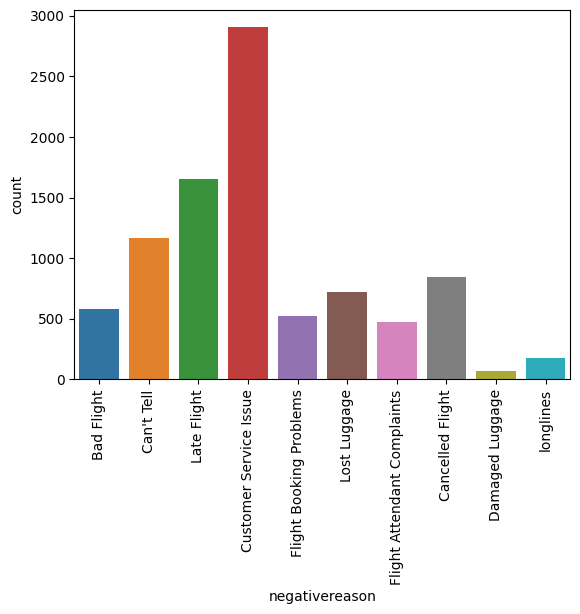

In [11]:
#Now we will try to plot the graph for visualization
import seaborn as sn
sn.countplot(data=data,x='negativereason')
plt.xticks(rotation=90);

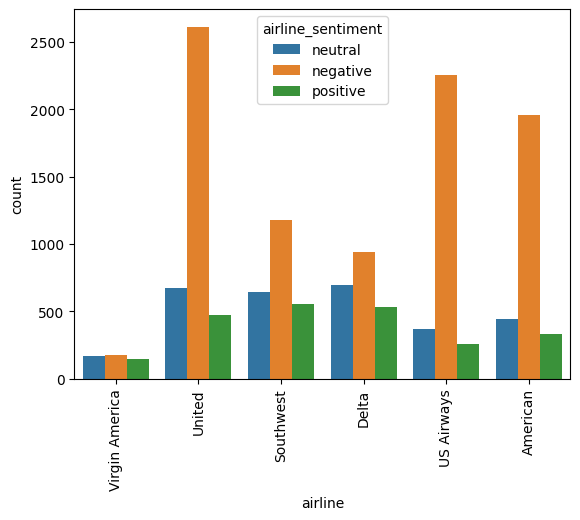

In [12]:
#Now we will try to plot the graph for visualization
sn.countplot(data=data,x="airline" ,hue='airline_sentiment')
plt.xticks(rotation=90);

In [13]:
tweets_df = pd.concat([data['text'], data['airline_sentiment']], axis=1)
tweets_df

text airline_sentiment
0                    @VirginAmerica What @dhepburn said.           neutral
1      @VirginAmerica I didn't today... Must mean I n...           neutral
2      @VirginAmerica it's really aggressive to blast...          negative
3      @VirginAmerica and it's a really big bad thing...          negative
4      @VirginAmerica seriously would pay $30 a fligh...          negative
...                                                  ...               ...
14397         @AmericanAir right on cue with the delays👌          negative
14398  @AmericanAir leaving over 20 minutes Late Flig...          negative
14399  @AmericanAir Please bring American Airlines to...           neutral
14400  @AmericanAir you have my money, you change my ...          negative
14401  @AmericanAir we have 8 ppl so we need 2 know h...           neutral

[14402 rows x 2 columns]

In [14]:
tweets_df.isna().sum().sum()

0

In [15]:
tweets_df['airline_sentiment'].value_counts()

negative    9113
neutral     2997
positive    2292
Name: airline_sentiment, dtype: int64

In [16]:
sentiment_ordering = ['negative', 'neutral', 'positive']

tweets_df['airline_sentiment'] = tweets_df['airline_sentiment'].apply(lambda x: sentiment_ordering.index(x))

In [17]:
tweets_df['airline_sentiment'].value_counts()

0    9113
1    2997
2    2292
Name: airline_sentiment, dtype: int64

In [18]:
emoji.demojize('@AmericanAir right on cue with the delays👌')

'@AmericanAir right on cue with the delays:OK_hand:'

In [19]:
tweets = tweets_df['text'].apply(process_tweet)

labels = np.array(tweets_df['airline_sentiment'])

In [20]:
tweets

0                                           [what, , said]
1        [i, didnt, today, must, mean, i, need, to, tak...
2        [it, realli, aggress, to, blast, obnoxi, enter...
3         [and, it, a, realli, big, bad, thing, about, it]
4        [serious, would, pay, dollar, a, flight, for, ...
                               ...                        
14397           [right, on, cue, with, the, delay, hand, ]
14398    [leav, over, number, minut, late, flight, no, ...
14399    [pleas, bring, american, airlin, to, blackberr...
14400    [you, have, my, money, you, chang, my, flight,...
14401    [we, have, number, ppl, so, we, need, number, ...
Name: text, Length: 14402, dtype: object

In [21]:
# Get size of vocabulary
#here we Calculating Maximum Sequence Length of each tweet (for example, it calculates the length (number of words) and updates the max_len variable if the current tweet's length is greater than the current maximum)
vocabulary = set()

for tweet in tweets:
    for word in tweet:
        if word not in vocabulary:
            vocabulary.add(word)

vocab_length = len(vocabulary)

# Get max length of a sequence
max_seq_length = 0

for tweet in tweets:
    if len(tweet) > max_seq_length:
        max_seq_length = len(tweet)

# Print results
print("Vocab length:", vocab_length)
print("Max sequence length:", max_seq_length)

Vocab length: 11250
Max sequence length: 90


In [22]:
GRU_tokenizer = Tokenizer(num_words=vocab_length)
GRU_tokenizer.fit_on_texts(tweets)
sequences = GRU_tokenizer.texts_to_sequences(tweets)
word_index = GRU_tokenizer.word_index
model_inputs = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
tokenizer_path = 'GRU_MODEL.pickle'
with open(tokenizer_path, 'wb') as tkn:
    pickle.dump(GRU_tokenizer, tkn, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
model_inputs

array([[  49,    2,  218, ...,    0,    0,    0],
       [   5,  191,  102, ...,    0,    0,    0],
       [  15,  138, 2841, ...,    0,    0,    0],
       ...,
       [  76,  507,  435, ...,    0,    0,    0],
       [   8,   19,   12, ...,    0,    0,    0],
       [  37,   19,    4, ...,    0,    0,    0]], dtype=int32)

In [24]:
model_inputs.shape

(14402, 90)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(model_inputs, labels, train_size=0.7, random_state=22)

### Training

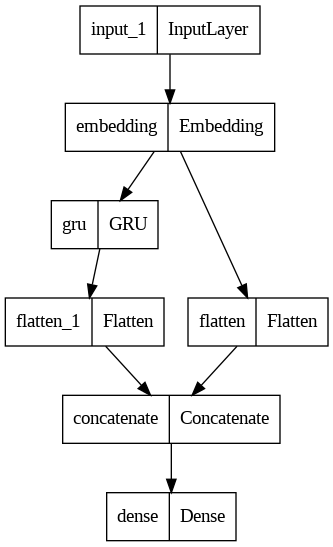

In [26]:
embedding_dim = 32


inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(inputs)


# Model A (just a Flatten layer)
flatten = tf.keras.layers.Flatten()(embedding)

# Model B (GRU with a Flatten layer)
gru = tf.keras.layers.GRU(units=embedding_dim)(embedding)
gru_flatten = tf.keras.layers.Flatten()(gru)

# Both A and B are fed into the output
concat = tf.keras.layers.concatenate([flatten, gru_flatten])

outputs = tf.keras.layers.Dense(3, activation='softmax')(concat)


GRU_model = tf.keras.Model(inputs, outputs)

tf.keras.utils.plot_model(GRU_model)

In [27]:
GRU_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

batch_size = 32
epochs = 100
GRU_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 90, 32)       360000      ['input_1[0][0]']                
                                                                                                  
 gru (GRU)                      (None, 32)           6336        ['embedding[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 2880)         0           ['embedding[0][0]']              
                                                                                              

In [ ]:
GRU_history = GRU_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/100
252/252 [==============================] - 9s 27ms/step - loss: 0.7923 - accuracy: 0.6644 - val_loss: 0.6659 - val_accuracy: 0.7318 - lr: 0.0010
Epoch 2/100
252/252 [==============================] - 6s 25ms/step - loss: 0.5201 - accuracy: 0.8011 - val_loss: 0.5418 - val_accuracy: 0.7774 - lr: 0.0010
Epoch 3/100
252/252 [==============================] - 6s 25ms/step - loss: 0.3695 - accuracy: 0.8699 - val_loss: 0.5097 - val_accuracy: 0.7942 - lr: 0.0010
Epoch 4/100
252/252 [==============================] - 6s 25ms/step - loss: 0.2742 - accuracy: 0.9108 - val_loss: 0.5090 - val_accuracy: 0.8042 - lr: 0.0010
Epoch 5/100
252/252 [==============================] - 6s 25ms/step - loss: 0.2059 - accuracy: 0.9384 - val_loss: 0.5202 - val_accuracy: 0.7982 - lr: 0.0010
Epoch 6/100
252/252 [==============================] - 6s 25ms/step - loss: 0.1545 - accuracy: 0.9588 - val_loss: 0.5395 - val_accuracy: 0.7942 - lr: 0.0010
Epoch 7/100
252/252 [==============================] - 6s 

### Results

In [ ]:
GRU_model.evaluate(X_test, y_test)

136/136 [==============================] - 1s 8ms/step - loss: 0.4954 - accuracy: 0.8070


[0.4954230785369873, 0.8069891333580017]

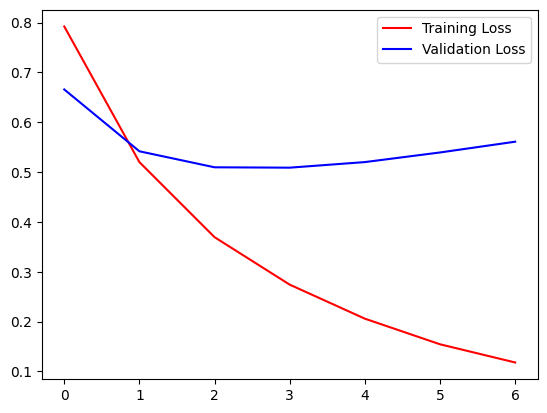

In [ ]:
plt.plot(GRU_history.history["loss"],'r', label="Training Loss")
plt.plot(GRU_history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

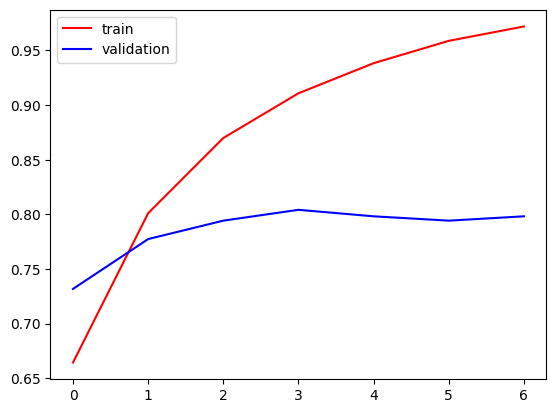

In [ ]:
plt.plot(GRU_history.history['accuracy'],color='red',label='train')
plt.plot(GRU_history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
model_predict = GRU_model.predict(X_test)
model_predict

136/136 [==============================] - 1s 8ms/step


array([[0.9289059 , 0.06768199, 0.00341212],
       [0.9105182 , 0.05876638, 0.03071532],
       [0.7942456 , 0.1879869 , 0.01776741],
       ...,
       [0.7786654 , 0.19547896, 0.02585558],
       [0.95586514, 0.02036766, 0.02376722],
       [0.64206064, 0.28937083, 0.06856853]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
score = GRU_model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.4954230785369873
Test accuracy: 0.8069891333580017


In [ ]:
GRU_model.save('GRU.h5')

-------------------------------------------------------------------------------- **END OF SECTION 2** ----------------------------------------------------------------------------------

# SECTION 3

## RNN Model

In [ ]:
import pandas as pnds
import numpy as npy
import seaborn as snsb
from sklearn.model_selection import train_test_split as tt_splt
from sklearn.preprocessing import LabelEncoder as lencdr
from tensorflow.keras.preprocessing.text import Tokenizer as tknzr
from tensorflow.keras.preprocessing.sequence import pad_sequences as psqnc
from tensorflow.keras.models import Sequential as sqntl
from tensorflow.keras.layers import Embedding as embdng, SimpleRNN as rnn,Dense  as dnse
from nltk.tokenize import word_tokenize as wrd_tknz
from nltk.corpus import stopwords as stp_wrds
from nltk.stem import PorterStemmer as pstmr
from sklearn.metrics import accuracy_score as acr_scr,precision_score as prcs_scr,recall_score as rcall_scr,f1_score as f1_scr, classification_report as clsfctn_rprt, confusion_matrix as cnfsn_mtrx
import matplotlib.pyplot as mplt
from sklearn.preprocessing import label_binarize as lbl_bnrz
from sklearn.metrics import  precision_recall_curve as prcs_rcall_crv, roc_curve as r_crv, auc


# Load the dataset
d_st = pnds.read_csv('Tweets.csv')
print("Twitter airline dataset")
d_st.head()

Twitter airline dataset


tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

### Preprocessing

In [ ]:
# Data Preprocessing

d_st['text'] = d_st['text'].apply(lambda x: x.lower())

d_st['tokens'] = d_st['text'].apply(lambda x: wrd_tknz(x))

s_wrd = set(stp_wrds.words('english'))
d_st['filtered_tokens'] = d_st['tokens'].apply(lambda tokens: [word for word in tokens if word.lower() not in s_wrd])

d_st['filtered_tokens'] = d_st['filtered_tokens'].apply(lambda tokens: [word for word in tokens if word.isalpha()])

stmr = pstmr()
d_st['stemmed_tokens'] = d_st['filtered_tokens'].apply(lambda tokens: [stmr.stem(word) for word in tokens])

print("\n Preprocessed dataset")
d_st[['text', 'filtered_tokens', 'stemmed_tokens']].head()


 Preprocessed dataset


text  \
0                @virginamerica what @dhepburn said.   
1  @virginamerica plus you've added commercials t...   
2  @virginamerica i didn't today... must mean i n...   
3  @virginamerica it's really aggressive to blast...   
4  @virginamerica and it's a really big bad thing...   

                                     filtered_tokens  \
0                    [virginamerica, dhepburn, said]   
1  [virginamerica, plus, added, commercials, expe...   
2  [virginamerica, today, must, mean, need, take,...   
3  [virginamerica, really, aggressive, blast, obn...   
4           [virginamerica, really, big, bad, thing]   

                                      stemmed_tokens  
0                    [virginamerica, dhepburn, said]  
1  [virginamerica, plu, ad, commerci, experi, tacki]  
2  [virginamerica, today, must, mean, need, take,...  
3  [virginamerica, realli, aggress, blast, obnoxi...  
4           [virginamerica, realli, big, bad, thing]

### Model Training

In [ ]:
# columns 'text' for tweets and 'label' for sentiment
twts = d_st['text'].astype(str)
sntmnts = d_st['airline_sentiment']

le = lencdr()
sntmnts = le.fit_transform(sntmnts)

# Split thw training and testing dataset
twts_trn, twts_tst, sntmnts_trn, sntmnts_tst = tt_splt(
    twts, sntmnts, test_size=0.2, random_state=42
)

# Tokenize the text data and Convert sequences and pad them for equal length
tknizr = tknzr(num_words=5000)
tknizr.fit_on_texts(twts_trn)
twts_trn_seq = tknizr.texts_to_sequences(twts_trn)
twts_tst_seq = tknizr.texts_to_sequences(twts_tst)

max_sequence_length = max(len(seq) for seq in twts_trn_seq)
twts_trn_padded = psqnc(twts_trn_seq, maxlen=max_sequence_length)
twts_tst_padded = psqnc(twts_tst_seq, maxlen=max_sequence_length)

# Build RNN model
rnn_model = sqntl()
rnn_model.add(embdng(input_dim=5000, output_dim=32, input_length=max_sequence_length))
rnn_model.add(rnn(32))
rnn_model.add(dnse(1, activation='sigmoid'))

# Compile, train and avaluate the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.fit(twts_trn_padded, sntmnts_trn, epochs=10, validation_split=0.1)
loss, accuracy = rnn_model.evaluate(twts_tst_padded, sntmnts_tst)
print(f'\n Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10
330/330 [==============================] - 5s 9ms/step - loss: 0.3182 - accuracy: 0.5723 - val_loss: -0.0240 - val_accuracy: 0.6638
Epoch 2/10
330/330 [==============================] - 3s 8ms/step - loss: -0.5479 - accuracy: 0.6816 - val_loss: -0.7203 - val_accuracy: 0.6305
Epoch 3/10
330/330 [==============================] - 3s 8ms/step - loss: -1.7092 - accuracy: 0.6997 - val_loss: -1.2882 - val_accuracy: 0.6357
Epoch 4/10
330/330 [==============================] - 3s 8ms/step - loss: -3.0781 - accuracy: 0.7120 - val_loss: -2.2175 - val_accuracy: 0.6485
Epoch 5/10
330/330 [==============================] - 3s 8ms/step - loss: -4.6314 - accuracy: 0.7219 - val_loss: -3.0056 - val_accuracy: 0.6195
Epoch 6/10
330/330 [==============================] - 3s 8ms/step - loss: -6.2791 - accuracy: 0.7320 - val_loss: -3.6024 - val_accuracy: 0.6203
Epoch 7/10
330/330 [==============================] - 3s 8ms/step - loss: -6.6922 - accuracy: 0.7271 - val_loss: -3.9375 - val_accuracy: 

### Testing the trained model on unknown dataset

  0% 0.00/71.0k [00:00<?, ?B/s]
100% 71.0k/71.0k [00:00<00:00, 87.6MB/s]
Archive:  appletwittersentimenttexts.zip
  inflating: apple-twitter-sentiment-texts.csv  

 New Data for Sentiment Analysis Prediction:
                                                text  sentiment
0  Wow. Yall needa step it up @Apple RT @heynyla:...         -1
1  What Happened To Apple Inc?   http://t.co/FJEX...          0
2  Thank u @apple I can now compile all of the pi...          1
3  The oddly uplifting story of the Apple co-foun...          0
4  @apple can i exchange my iphone for a differen...          0
51/51 [==============================] - 0s 3ms/step

 Predictions for New Data:
                                                   text predicted_label
0     Wow. Yall needa step it up @Apple RT @heynyla:...         neutral
1     What Happened To Apple Inc?   http://t.co/FJEX...         neutral
2     Thank u @apple I can now compile all of the pi...         neutral
3     The oddly uplifting story of the

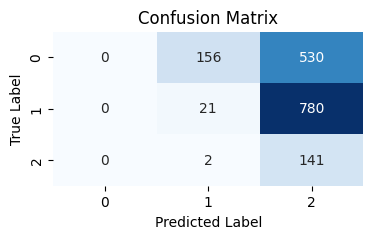

In [ ]:
!kaggle datasets download -d seriousran/appletwittersentimenttexts
!unzip -o appletwittersentimenttexts
# new dataset
new_data = pnds.read_csv('apple-twitter-sentiment-texts.csv')  # Replace 'your_new_data.csv' with the actual file path
print("\n New Data for Sentiment Analysis Prediction:")
print(new_data.head())

# Tokenize and pad the sequences and Make predictions on new data
new_sqncs = tknizr.texts_to_sequences(new_data['text'])
new_pded_sqncs = psqnc(new_sqncs, maxlen=max_sequence_length)
new_prdcts_probs = rnn_model.predict(new_pded_sqncs)
new_predictions = (new_prdcts_probs > 0.5).astype(int)

# Convert predictions to 1D array
new_predictions = new_predictions.flatten()
new_data['predicted_label'] = le.inverse_transform(new_predictions)
print("\n Predictions for New Data:")
print(new_data[['text', 'predicted_label']])

# Confusion Matrix for sentiment analysis
conf_matrix = cnfsn_mtrx(new_data['sentiment'], new_predictions)  # Use the appropriate variable here
print("\nConfusion Matrix:")
print(conf_matrix)
mplt.figure(figsize=(4, 2))
snsb.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
mplt.title('Confusion Matrix')
mplt.xlabel('Predicted Label')
mplt.ylabel('True Label')
mplt.show()


### Visualizations

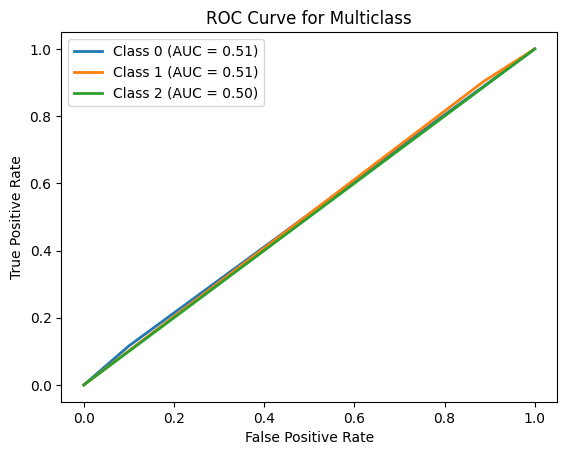

In [ ]:
# Binarize the labels using unique classes from the training data
unq_clsses = npy.unique(sntmnts_tst)
y_tst_bin = lbl_bnrz(sntmnts_tst, classes=unq_clsses)

new_prdcts_probs_bin = lbl_bnrz(new_predictions, classes=unq_clsses)
num_samples_y_tst_bin = y_tst_bin.shape[0]
num_samples_new_prdcts_probs_bin = new_prdcts_probs_bin.shape[0]

if num_samples_new_prdcts_probs_bin < num_samples_y_tst_bin:
    y_tst_bin = y_tst_bin[:num_samples_new_prdcts_probs_bin, :]
elif num_samples_new_prdcts_probs_bin > num_samples_y_tst_bin:
    new_prdcts_probs_bin = new_prdcts_probs_bin[:num_samples_y_tst_bin, :]

# Now compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = len(unq_clsses)
for i in range(num_classes):
    fpr[i], tpr[i], _ = r_crv(y_tst_bin[:, i], new_prdcts_probs_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    mplt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
mplt.xlabel("False Positive Rate")
mplt.ylabel("True Positive Rate")
mplt.title("ROC Curve for Multiclass")
mplt.legend(loc="best")
mplt.show()

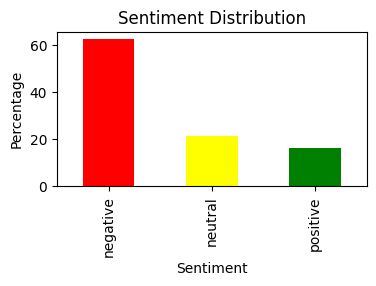

In [ ]:
# Bar Chart for Sentiment Distribution
sentiment_distribution = d_st['airline_sentiment'].value_counts(normalize=True) * 100
mplt.figure(figsize=(4, 2))
sentiment_distribution.plot(kind='bar', color=['red', 'yellow', 'green'])
mplt.xlabel('Sentiment')
mplt.ylabel('Percentage')
mplt.title('Sentiment Distribution')
mplt.show()

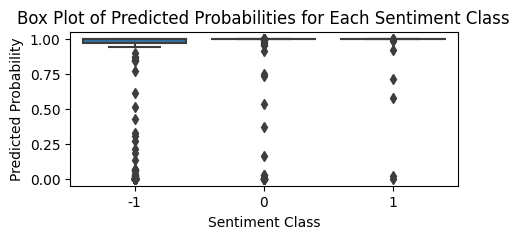

In [ ]:
mplt.figure(figsize=(5, 2))
snsb.boxplot(x='sentiment', y=new_prdcts_probs.flatten(), data=new_data)
mplt.title('Box Plot of Predicted Probabilities for Each Sentiment Class')
mplt.xlabel('Sentiment Class')
mplt.ylabel('Predicted Probability')
mplt.show()

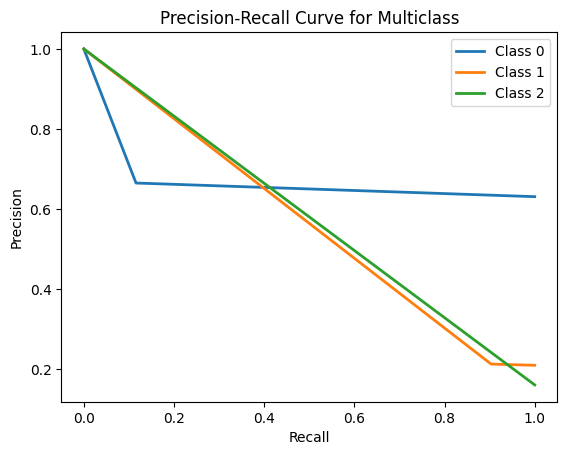

In [ ]:
#  Precision-Recall Curve:
precision = dict()
recall = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = prcs_rcall_crv(y_tst_bin[:, i], new_prdcts_probs_bin[:, i])
    mplt.plot(recall[i], precision[i], lw=2, label=f'Class {i}')
mplt.xlabel("Recall")
mplt.ylabel("Precision")
mplt.title("Precision-Recall Curve for Multiclass")
mplt.legend(loc="best")
mplt.show()

Classification Report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       686
     Neutral       0.12      0.03      0.04       801
    Positive       0.10      0.99      0.18       143

    accuracy                           0.10      1630
   macro avg       0.07      0.34      0.07      1630
weighted avg       0.07      0.10      0.04      1630



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


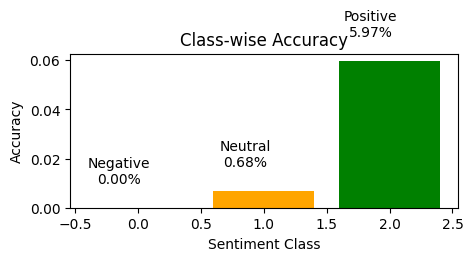

In [ ]:
class_counts = d_st['airline_sentiment'].value_counts().sort_index()
class_accuracy = npy.diag(conf_matrix) / class_counts
colors = ['red', 'orange', 'green']
# Class-wise Accuracy
class_meanings = {
    0: 'Negative',
    1: 'Neutral',
    2: 'Positive'
}
mplt.figure(figsize=(5, 2))
bars = mplt.bar(unq_clsses, class_accuracy, color=colors)
# Calculate precision, recall, F1 score
y_true = new_data['sentiment']
classification_rep = clsfctn_rprt(y_true, new_predictions, target_names=class_meanings.values())
print("Classification Report:\n", classification_rep)

for bar, label, percentage in zip(bars, unq_clsses, class_accuracy):
    mplt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.01,
             f'{class_meanings[label]}\n{percentage * 100:.2f}%', ha='center', color='black')

mplt.xlabel('Sentiment Class')
mplt.ylabel('Accuracy')
mplt.title('Class-wise Accuracy')
mplt.show()

-------------------------------------------------------------------------------- **END OF SECTION 3** ----------------------------------------------------------------------------------

# SECTION 4

## **TRANSFER LEARNING**

### Working with a different kaggle Dataset

***Implementing Transfer learning with the models trained in previous step on "apple twitter" dataset. This dataset only has 1630 rows in it, thus making it a good example for transfer learning.***

In [ ]:
!kaggle datasets list -s "apple twitter"

ref                                                          title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
seriousran/appletwittersentimenttexts                        apple_twitter_sentiment_texts                       71KB  2020-05-14 03:19:25           2040         32  1.0              
shivamb/company-acquisitions-7-top-companies                 Merger and Acquisitions by Tech Companies           31KB  2021-10-24 10:03:06           4915        178  1.0              
omermetinn/tweets-about-the-top-companies-from-2015-to-2020  Tweets about the Top Companies from 2015 to 2020   278MB  2020-11-26 16:25:11          11469        240  1.0              
slythe/apple-twitter-sentiment-crowdflower                   Apple Twitter Senti

In [ ]:
!kaggle datasets download -d seriousran/appletwittersentimenttexts
!unzip -o appletwittersentimenttexts

appletwittersentimenttexts.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  appletwittersentimenttexts.zip
  inflating: apple-twitter-sentiment-texts.csv  


In [ ]:
df_transfer = pd.read_csv('apple-twitter-sentiment-texts.csv')

In [ ]:
df_transfer.head(5)

text  sentiment
0  Wow. Yall needa step it up @Apple RT @heynyla:...         -1
1  What Happened To Apple Inc?   http://t.co/FJEX...          0
2  Thank u @apple I can now compile all of the pi...          1
3  The oddly uplifting story of the Apple co-foun...          0
4  @apple can i exchange my iphone for a differen...          0

In [ ]:
df_transfer['sentiment'] = df_transfer['sentiment'].apply(equalise)
df_transfer2 = df_transfer.copy()
df_transfer2.columns = ['Tweet','Target']
df_transfer2['Tweet'] = df_transfer2['Tweet'].apply(tweet_cleansing)
df_transfer2

Tweet    Target
0              wow step appl music damn time thank note  negative
1                                  happen appl inc appl   neutral
2              thank u appl compil pic commun one place  positive
3            oddli uplift stori appl cofound sold stake   neutral
4                  appl exchang differ color chang mind   neutral
...                                                 ...       ...
1625                           pick slack fuck boy appl  negative
1626     final got mail come box bust screen thank appl  negative
1627  appl end get new comput anyhow work comput her...   neutral
1628                  turn appl nab back hollywood star   neutral
1629       may longer upgrad cycl expect unit sale fall  negative

[1630 rows x 2 columns]

<Axes: >

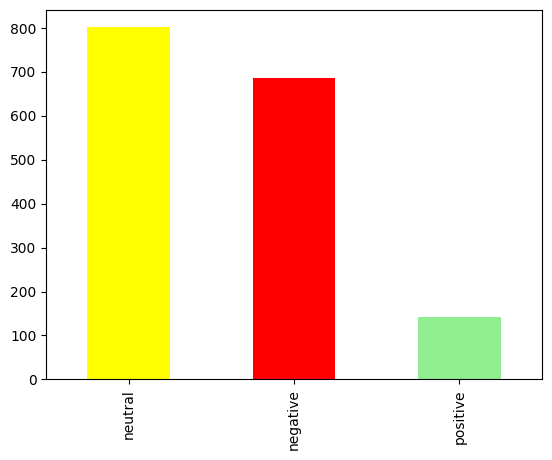

In [ ]:
df_transfer2['Target'].value_counts().plot(kind='bar', color=['yellow', 'red', 'lightgreen'])

In [ ]:
tf.keras.backend.clear_session()

### Train Test Split - Cleansed Data

In [ ]:
# This train test split will split the X and Y, train and Test data splits from the Cleansed dataset
X_transfer = df_transfer2['Tweet']
y_transfer = df_transfer2['Target']
# Encode labels for the new dataset
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_transfer)
num_classes = len(label_encoder.classes_)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_transfer, y_encoded, test_size=0.2, random_state=42, shuffle=True,stratify=y_encoded)
# Tokenize and pad sequences
max_words = 10000
max_len = 100

#### Pre-Trained Models

#### LSTM - Cleansed

In [ ]:
with open("LSTM_C.pickle", 'rb') as handle:
    tokenizer = pickle.load(handle)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
# loading pre-trained model
pre_trained_model = load_model('LSTM.h5')
# adding extra layers
transfer_model = Sequential()
transfer_model.add(pre_trained_model.layers[0])
transfer_model.add(pre_trained_model.layers[1])
#transfer_model.add(pre_trained_model.layers[2])
transfer_model.add(Dense(50))
transfer_model.add(Dense(3, activation='softmax'))
for l, layer in enumerate(transfer_model.layers[:-2]):
    layer.trainable = False
# freezing old layer
for l, layer in enumerate(transfer_model.layers[-2:]):
    layer.trainable = True
transfer_model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()
# Train the transfer model with our new data
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
transfer_model.fit(X_train_pad, y_train, epochs=25, batch_size=32, validation_split=0.2,shuffle=True,callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 1,085,603
Trainable params: 5,203
Non-trainable params: 1,080,400
_________________________________________________________________
Epoch 1/25
33/33 [==============================] - 4s 45ms/step - loss: 0.8394 - accuracy: 0.6711 - val_loss: 0.7084 - val_accuracy: 0.7356
Epoch 2/25
33/33 [===============

In [ ]:
loss, accuracy = transfer_model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

11/11 [==============================] - 0s 21ms/step - loss: 0.6890 - accuracy: 0.7055
Test Loss: 0.6890455484390259, Test Accuracy: 0.7055214643478394


11/11 [==============================] - 1s 20ms/step


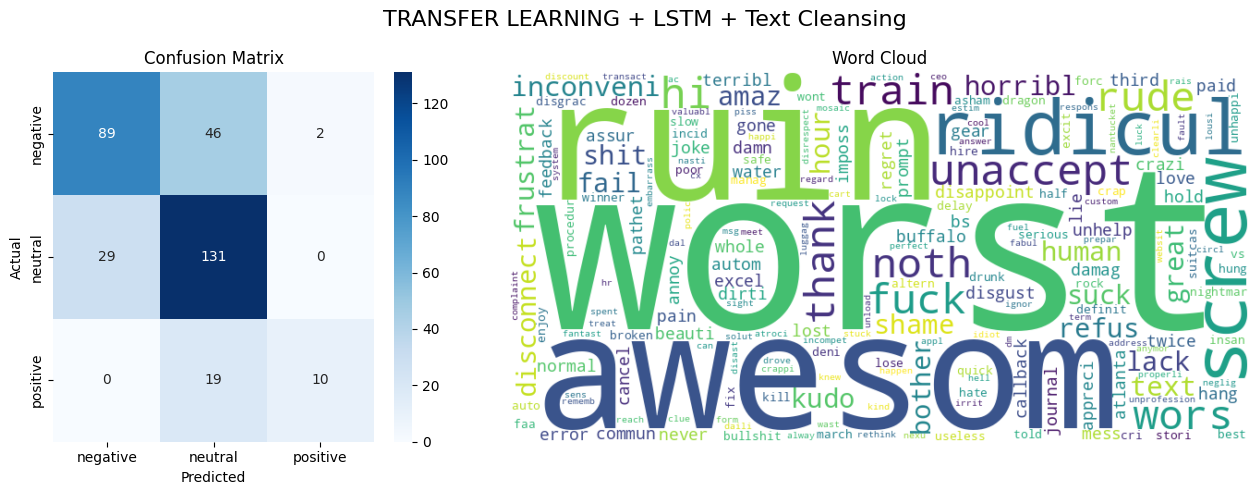

In [ ]:
plotter(transfer_model,X_test_pad,y_test,"TRANSFER LEARNING + LSTM + Text Cleansing",tokenizer)

#### Attention - Cleansed

In [ ]:
from keras.utils import custom_object_scope
with open("ATTENTION_C.pickle", 'rb') as handle:
    tokenizer = pickle.load(handle)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
# loading pre-trained model
with custom_object_scope({'SeqSelfAttention': SeqSelfAttention}):
    pre_trained_model = load_model('Attention.h5')
# adding extra layers
transfer_model = Sequential()
transfer_model.add(pre_trained_model.layers[0])
transfer_model.add(pre_trained_model.layers[1])
transfer_model.add(pre_trained_model.layers[2])
transfer_model.add(pre_trained_model.layers[3])
transfer_model.add(Dense(50))
transfer_model.add(Dense(3, activation='softmax',name='out'))
for l, layer in enumerate(transfer_model.layers[:-2]):
    layer.trainable = False
# freezing old layer
for l, layer in enumerate(transfer_model.layers[-2:]):
    layer.trainable = True
transfer_model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()
# Train the transfer model with our new data
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
transfer_model.fit(X_train_pad, y_train, epochs=25, batch_size=32, validation_split=0.1,shuffle=True,callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           500000    
                                                                 
 lstm_2 (LSTM)               (None, 100, 100)          60400     
                                                                 
 Attention (SeqSelfAttention  (None, 100, 100)         6465      
 )                                                               
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 50)                500050    
                                                                 
 out (Dense)                 (None, 3)                 153       
                                                      

In [ ]:
loss, accuracy = transfer_model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

11/11 [==============================] - 0s 32ms/step - loss: 0.6786 - accuracy: 0.7178
Test Loss: 0.6786091923713684, Test Accuracy: 0.7177914381027222


11/11 [==============================] - 1s 30ms/step


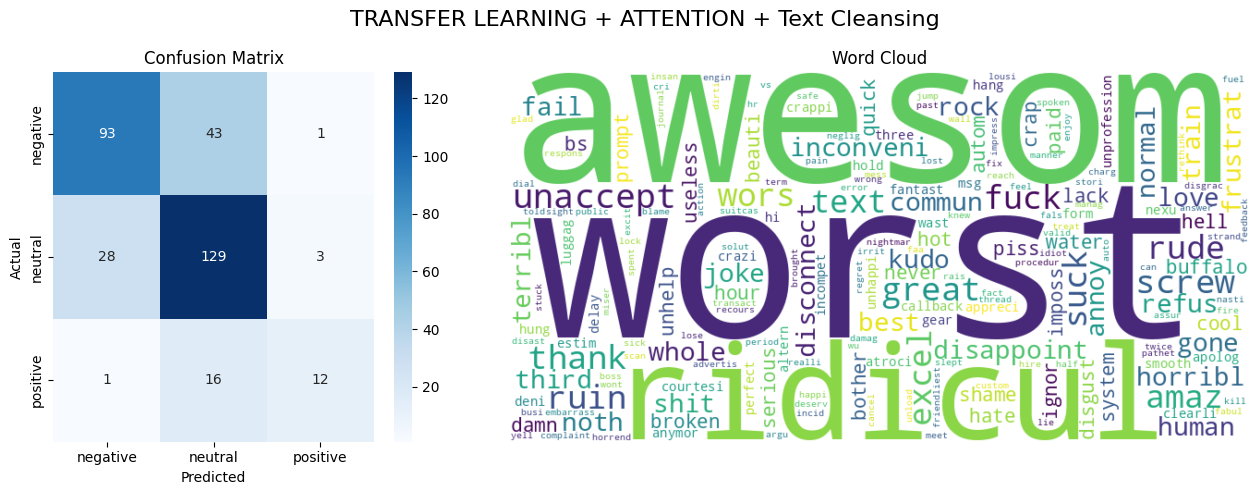

In [ ]:
plotter(transfer_model,X_test_pad,y_test,"TRANSFER LEARNING + ATTENTION + Text Cleansing",tokenizer)

### Train Test Split - unCleaned Data

In [ ]:
# This train test split will split the X and Y, train and Test data splits from the unCleaned dataset
X_transfer = df_transfer['text']
y_transfer = df_transfer['sentiment']
# Encode labels for the new dataset
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_transfer)
num_classes = len(label_encoder.classes_)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_transfer, y_encoded, test_size=0.2, random_state=42, shuffle=True)
# Tokenize and pad sequences
max_words = 10000
max_len = 100

#### LSTM - unCleaned

In [ ]:
with open("LSTM_U.pickle", 'rb') as handle:
    tokenizer = pickle.load(handle)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
# loading pre-trained model
pre_trained_model = load_model('LSTM_unCleaned.h5')
# adding extra layers
transfer_model = Sequential()
transfer_model.add(pre_trained_model.layers[0])
transfer_model.add(pre_trained_model.layers[1])
#transfer_model.add(pre_trained_model.layers[2])
transfer_model.add(Dense(50))
transfer_model.add(Dense(3, activation='softmax'))
for l, layer in enumerate(transfer_model.layers[:-2]):
    layer.trainable = False
# freezing old layer
for l, layer in enumerate(transfer_model.layers[-2:]):
    layer.trainable = True
transfer_model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()
# Training the transfer model with our new data
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
transfer_model.fit(X_train_pad, y_train, epochs=25, batch_size=32, validation_split=0.1,shuffle=True,callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dense_4 (Dense)             (None, 3)                 153       
                                                                 
Total params: 1,085,603
Trainable params: 5,203
Non-trainable params: 1,080,400
_________________________________________________________________
Epoch 1/25
37/37 [==============================] - 3s 39ms/step - loss: 0.7960 - accuracy: 0.6820 - val_loss: 0.5760 - val_accuracy: 0.7710
Epoch 2/25
37/37 [=============

In [ ]:
loss, accuracy = transfer_model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

11/11 [==============================] - 0s 19ms/step - loss: 0.6218 - accuracy: 0.7669
Test Loss: 0.6218334436416626, Test Accuracy: 0.7668711543083191


11/11 [==============================] - 1s 19ms/step


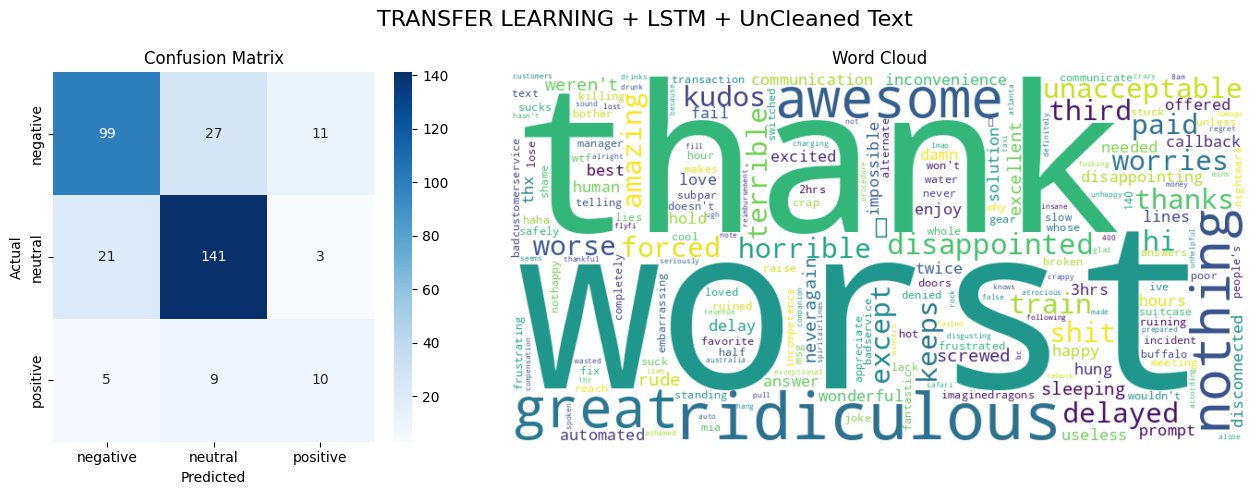

In [ ]:
plotter(transfer_model,X_test_pad,y_test,"TRANSFER LEARNING + LSTM + UnCleaned Text",tokenizer)

#### Attention unCleaned

In [ ]:
with open("ATTENTION_U.pickle", 'rb') as handle:
    tokenizer = pickle.load(handle)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
# loading pre-trained model
with custom_object_scope({'SeqSelfAttention': SeqSelfAttention}):
    pre_trained_model = load_model('Attention_unCleaned.h5')
# adding extra layers
transfer_model = Sequential()
transfer_model.add(pre_trained_model.layers[0])
transfer_model.add(pre_trained_model.layers[1])
transfer_model.add(pre_trained_model.layers[2])
transfer_model.add(pre_trained_model.layers[3])
transfer_model.add(Dense(50))
transfer_model.add(Dense(3, activation='softmax',name='out'))
for l, layer in enumerate(transfer_model.layers[:-2]):
    layer.trainable = False
# freezing old layers
for l, layer in enumerate(transfer_model.layers[-2:]):
    layer.trainable = True
transfer_model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()
# Training the transfer model with new data
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
transfer_model.fit(X_train_pad, y_train, epochs=25, batch_size=32, validation_split=0.1,shuffle=True,callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 50)           500000    
                                                                 
 lstm_3 (LSTM)               (None, 100, 100)          60400     
                                                                 
 Attention (SeqSelfAttention  (None, 100, 100)         6465      
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_5 (Dense)             (None, 50)                500050    
                                                                 
 out (Dense)                 (None, 3)                 153       
                                                      

In [ ]:
loss, accuracy = transfer_model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

11/11 [==============================] - 0s 33ms/step - loss: 0.5786 - accuracy: 0.7761
Test Loss: 0.5785506367683411, Test Accuracy: 0.7760736346244812


11/11 [==============================] - 1s 32ms/step


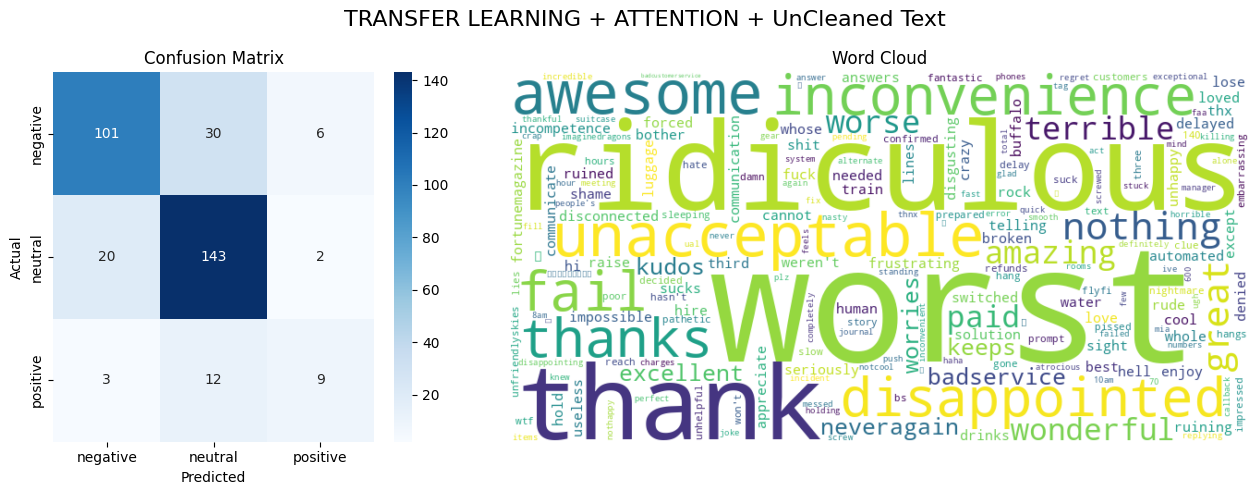

In [ ]:
plotter(transfer_model,X_test_pad,y_test,"TRANSFER LEARNING + ATTENTION + UnCleaned Text",tokenizer)

# CONCLUSION

Out of all models, LSTM and Attention performed well in the training data hence I have used these two for transfer learning. Out of this, the Attention model with unCleaned data gives the highest accuracy. This makes sence because the Attention model gives scores for different words from the sentences based on the importance of those words. This itself is a type of pre-processing by finding out which words to look for. Hence the Transfer Learning done using Attention model with unCleaned data gives the best results. The accuracy of models built using Transfer Learning can be exponentially high if it's done with a larger dataset (BERT Model). But, I wanted to create my own model and use it for transfer learning instead of just using a pre-trained one.